In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import copy
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression

In [ ]:
df = pd.read_csv("./data/seoul_bike.csv",encoding='ISO-8859-1')

df.head()

In [7]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

In [10]:
df = df.drop(["Date", "Holiday", 'Seasons'], axis=1)

In [13]:
df.columns = dataset_cols

In [17]:
df["functional"] = (df["functional"] == "Yes").astype(int)

In [20]:
df = df[df["hour"] == 12]

In [22]:
df = df.drop(["hour"], axis=1)

In [26]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp',
       'radiation', 'rain', 'snow', 'functional'],
      dtype='object')

In [27]:
df = df.drop(['visibility','wind', 'functional'], axis=1)

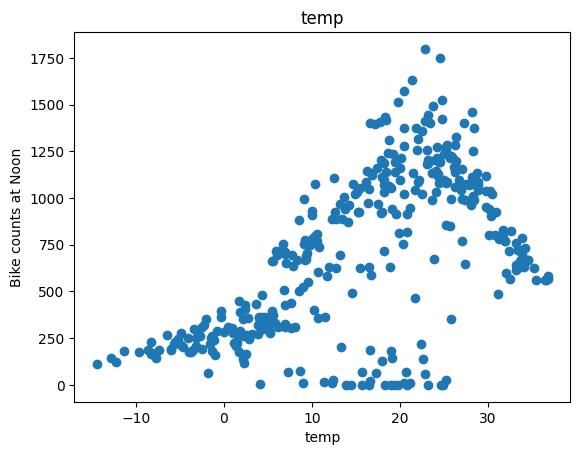

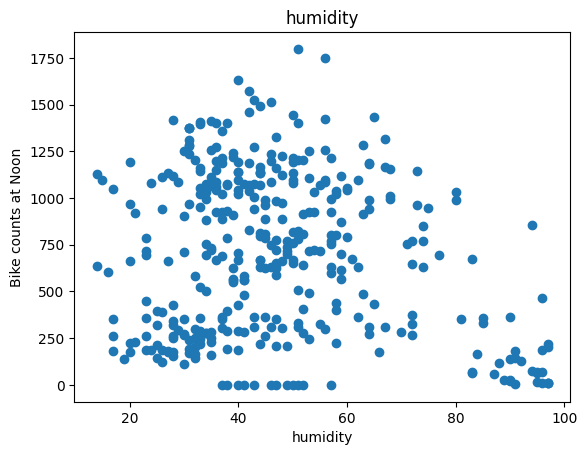

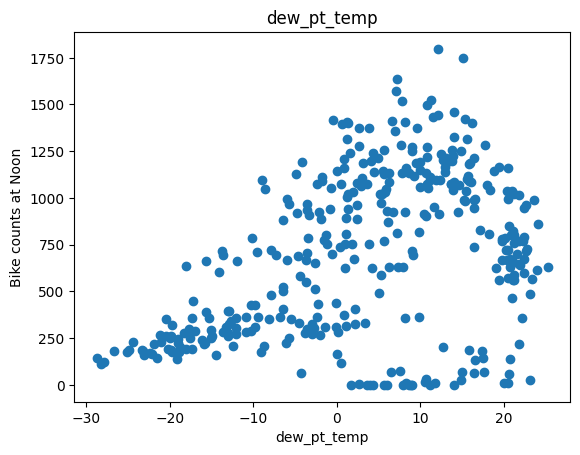

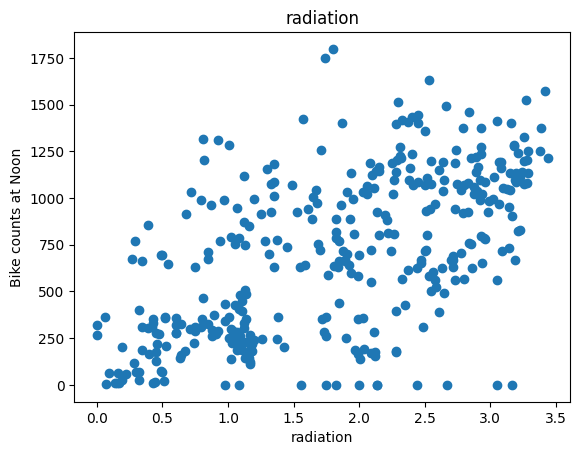

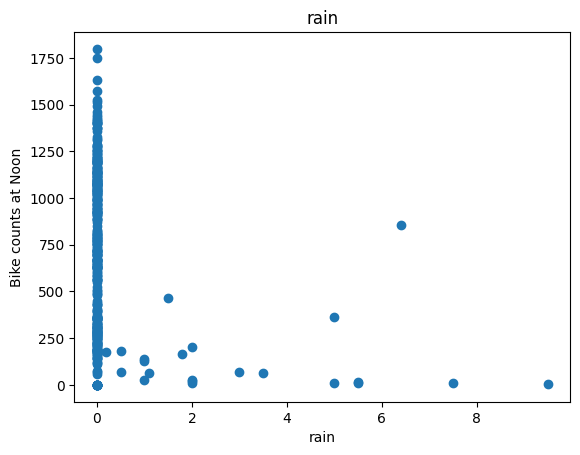

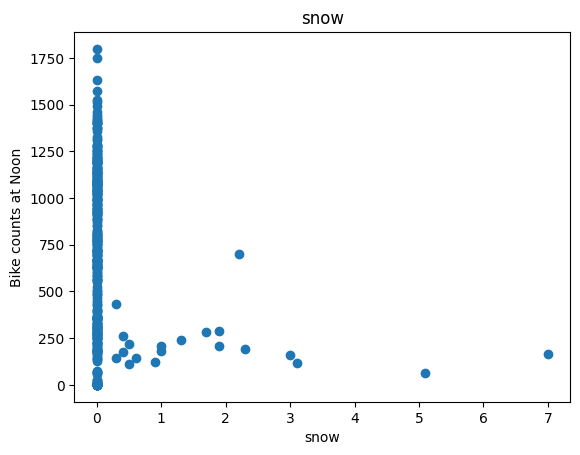

In [28]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel("Bike counts at Noon")
    plt.show()

In [30]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

C:\Users\baxti\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [33]:
def get_x_and_y(dataframe, y_label, x_label=None):
    dataframe = copy.deepcopy(dataframe)
    if not x_label:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]]
    else:
        if len(x_label) == 1:
            X = dataframe[x_label[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_label].values
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

In [36]:
_, X_train_temp, y_train_temp = get_x_and_y(train, "bike_count",x_label=["temp"])
_, X_val_temp, y_val_temp = get_x_and_y(val, "bike_count",x_label=["temp"])
_, X_test_temp, y_test_temp = get_x_and_y(test, "bike_count",x_label=["temp"])

In [38]:
lr = LinearRegression()
lr.fit(X_train_temp, y_train_temp)

LinearRegression()

In [39]:
print(lr.coef_, lr.intercept_)

[[21.87107919]] [382.65161299]


In [40]:
print(lr.score(X_test_temp, y_test_temp))

0.1545693842882626


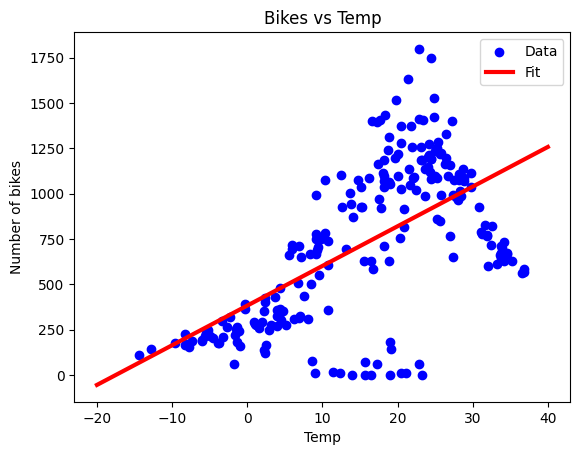

In [43]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, lr.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [45]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer, 
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])


nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,), loss="mean_squared_error")

In [46]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

In [47]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

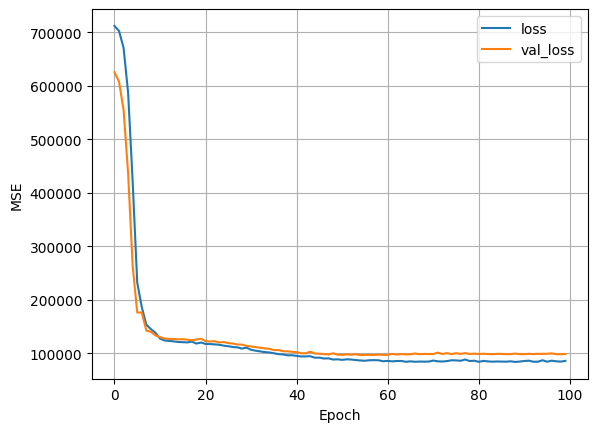

In [48]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


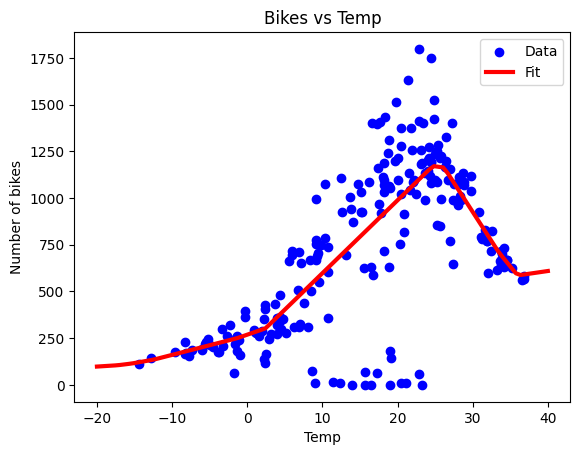

In [49]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()